Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import operator
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_validate

Import Models

In [2]:
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# NOT RECOMMENDED! ignore warnings
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

***

In [4]:
# TODO: Correlation summary

In [4]:
class SingleModelSearch:
    """
    TODO
        1. Review hyperparameters grid. 
        3. Add average training AUC
    
    Search for the best model type using cross validation.
    
    Parameters
    ----------
    n_iter: int
        Number of parameter settings that are sampled.
    cv: int
        Number of cross validation folds.
    scoring: string, default='roc_auc'
        Scoring metrics (e.g: AUC, Accuracy, F1, etc)
    n_jobs: int, default=None
        Number of thread to use for parallel computing.
    random_state: int, default=None
        Random seed for RandomizedSearchCV().
        Set seed to integer to get reproducible result.
    verbose: boolean, default=False
        Set to True to print messages when searching in progress.
        
    Attributes
    ----------
    model_search_params_: dict
        Contains all the optimal CV parameters for every searched model.
    model_search_score_: DataFrame
        Contains all the best CV score for every searched model.
    best_model_: dict
        Contains the name, parameters and score of best model.
    """
    _model = {
        'logistic': LogisticRegression(max_iter=1000),
        'lda': LinearDiscriminantAnalysis(), 
        'naivebayes': GaussianNB(),
        'rf': RandomForestClassifier(n_estimators=100),
        'xgboost': XGBClassifier(),
        'knn': KNeighborsClassifier(),
        'svc': SVC(kernel='rbf'),
        'mlp': MLPClassifier(max_iter=500)
    }
    
    _params_grid = {
        'logistic': {
            'solver' : ['liblinear', 'saga'],
            'C' : [1e-3, 1e-2, 0.1, 1, 10, 100]
        },
        'rf': {
            'max_depth': randint(10, 100),
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': randint(1, 4),
            'min_samples_split': randint(2, 10),
            'bootstrap': [True, False]
        },
        'xgboost': {
            'max_depth': randint(1,6),
            'min_child_weight': randint(0,6),
            'subsample': uniform(loc=0.6, scale=0.4),
            'colsample_bytree': uniform(loc=0.6, scale=0.4),
            'gamma': [i/10.0 for i in range(0,5)],
            'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
        }, 
        'knn': {
            'n_neighbors': randint(1, 100)
        },
        'svc': {
            'gamma': [0.1, 1, 10, 100],
            'C': [0.1, 1, 10, 100, 1000]
        },
        'mlp': {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive']
        }
    }
    def __init__(self, n_iter, cv, scoring='roc_auc', n_jobs=None,  
                 random_state=None, verbose=False):
        self.n_iter = n_iter
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.cv = cv
        self.random_state = random_state
        self.verbose = verbose
        
    def _get_params_score(self, X, y, model):
        """
        Find the optimal CV parameters and score for each model types.
        
        Parameters
        ----------
        X: DataFrame
            Input features
        Y: DataFrame
            Input label
        model: string
            Name of the model to be tested. (See class variables)
        
        Returns
        -------
        params: dict
            Best CV model parameters.
        score: int
            Best CV score. 
        """
        
        # valid model name that has searching grid
        if model in self._params_grid.keys():
            rand_search = RandomizedSearchCV(
                estimator = self._model[model],
                param_distributions = self._params_grid[model],
                scoring = self.scoring,
                n_iter = self.n_iter,
                cv = self.cv,
                n_jobs = self.n_jobs,
                random_state = self.random_state)
            
            rand_search.fit(X, y)
            
            return rand_search.best_params_, rand_search.best_score_
        # valid model name without searching grid
        elif model in self._model.keys():
            cv_fit = cross_validate(self._model[model], X, y, 
                                    scoring=self.scoring, cv=self.cv, 
                                    n_jobs=self.n_jobs)
            
            return self._model[model].get_params(), cv_fit['test_score'].mean()
        else:
            raise Exception('Invalid model! Please input a valid model name')
    
    
    def fit(self, X, y):
        """
        Parameters
        ----------
        X: DataFrame
            Input features
        Y: DataFrame
            Input label
        """
        # declare dtype for desired output
        self.model_search_params_ = {}
        self.model_search_score_ = pd.DataFrame([], columns=['model', 'score'])
        self.best_model_ = {}
        
        for model in self._model.keys():
            if self.verbose == True:
                print("Currently testing for {}".format(model))
                
            # find the CV results and optimal params
            params, score= self._get_params_score(X, y, model)
            
            # record best CV params & score
            self.model_search_params_[model] = params
            self.model_search_score_ = self.model_search_score_.\
                                       append({'model': model, 'score': score}, 
                                              ignore_index=True)
        
        # sort search results in descending order
        self.model_search_score_ = self.model_search_score_.\
                                   sort_values(by='score', ascending=False).\
                                   reset_index(drop=True)
        
        # extract the name, params and score for best model
        best_model = self.model_search_score_.\
                     loc[self.model_search_score_.score.idxmax(), :]
        
        self.best_model_['name'] = best_model.model
        self.best_model_['score'] = best_model.score
        self.best_model_['params'] = self.model_search_params_[best_model.model]
        

In [5]:
class BlendedModelSearch(SingleModelSearch):
    """
    TODO:
        1. Suggest candidate models (Check correlation - choose uncorrelated)
        2. Add average training AUC
    
    Search for the candidate models for blending using cross validation.
    
    Parameters
    ----------
    frac: float, range within (0, 1]
        Proportion of features that are sampled.
    n_experiments:
        Number of times to repeat the sampling plus searching process.
    n_iter: int
        Number of parameter settings that are sampled.
    cv: int
        Number of cross validation folds.
    scoring: string, default='roc_auc'
        Scoring metrics (e.g: AUC, Accuracy, F1, etc)
    n_jobs: int, default=None
        Number of thread to use for parallel computing.
    random_state: int, default=None
        Random seed for RandomizedSearchCV() and features sampling.
        Set seed to integer to get reproducible result.
    verbose: boolean, default=False
        Set to True to print messages when searching in progress.
        
    Attributes
    ----------
    model_search_params_: dict
        Contains all the optimal CV parameters for every searched model.
    model_search_score_: DataFrame
        Contains all the best CV score for every searched model.
    
    """
    def __init__(self, frac, n_experiment, n_iter, cv, scoring='roc_auc', 
                 n_jobs=None, random_state=None, verbose=False):
        super().__init__(n_iter=n_iter, cv=cv, scoring=scoring, n_jobs=n_jobs,
                         random_state=random_state, verbose=verbose)
        self.frac = frac
        self.n_experiment = n_experiment
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X: DataFrame
            Input features
        Y: DataFrame
            Input label
        """
        
        # declare dtype for the desired output
        self.model_search_params_ = {}
        self.model_search_score_ = pd.DataFrame(
            [], 
            columns=['experiment', 'model', 'score'])
        
        for i in range(self.n_experiment):
            
            # sample the features randomly
            X_sample = X.sample(frac=self.frac, axis=1,
                               random_state=self.random_state + i)
            y_sample = y
            
            # test for all model types
            for model in self._model.keys():
                if self.verbose == True:
                    print("Experiment {}: Testing for {}".format(i, model))
                
                # find the CV results and optimal params
                params, score = super()._get_params_score(
                    X_sample, y_sample, model)
                
                # save the searched parameters
                self.model_search_params_[(i, model)] = \
                    {'params': params, 'feature': list(X_sample.columns)}
                
                # save the search results
                self.model_search_score_ = \
                    self.model_search_score_.append(
                        {'experiment': i, 'model': model, 'score': score},
                         ignore_index=True)
        
        # sort the search results in descending order
        self.model_search_score_ = self.model_search_score_.\
                                   sort_values(by='score', ascending=False)\
                                   .reset_index(drop=True)

In [115]:
class CorrFilter:
    """
    Determine highly correlated pairs.
    
    Parameters
    ----------
    correlation_threshold: float, range = [0, 1]
        Threshold to be classified as 'highly correlated'
    
    Attributes
    ----------
    output: DataFrame
        Shows the correlated features pairs and their 
        corresponding correlated coefficent.
    """
    def __init__(self, correlation_threshold=0.8):
        self.correlation_threshold = correlation_threshold
        
    def fit(self, data):
        corr = data.corr()
    
        # Extract the upper triangle of the correlation matrix
        upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))

        record_collinear = pd.DataFrame(columns = ['pair1', 'pair2', 'corr'])

        # unique features that are correlated to some other feature
        to_drop = [column for column in upper.columns 
                   if any(upper[column].abs() > self.correlation_threshold)]

        for column in to_drop:
            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > 
                                             self.correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > 
                                             self.correlation_threshold])
            # duplicate len(corr_feat) times
            drop_features = [column for _ in range(len(corr_features))] 

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'pair1': drop_features,
                                              'pair2': corr_features,
                                              'corr': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        print(record_collinear)
        self.output = record_collinear
    
    def plot(self):
        """
        Visualise the correlated pairs. 
        """
        G = nx.from_pandas_edgelist(self.output, 'pair1', 'pair2')
        pos = nx.spring_layout(G, k=0.3*1/np.sqrt(len(G.nodes())), iterations=20)

        # Plot the network:
        nx.draw(G, with_labels=True, node_color='orange', node_size=400, 
                edge_color='black', linewidths=1, font_size=10)
        plt.show()

***

#### Demonstration

In [7]:
data = pd.read_csv("data.csv")

In [8]:
# Test single model mode
msearch = SingleModelSearch(n_iter=1, cv=3, verbose=True, n_jobs=-1)
msearch.fit(data.loc[:, ~data.columns.isin(['bookingID', 'label'])], data['label'])
msearch.model_search_score_

Currently testing for mlp
Currently testing for naivebayes
Currently testing for lda
Currently testing for svc
Currently testing for logistic
Currently testing for knn
Currently testing for rf
Currently testing for xgboost


,model,score
0,lda,0.715709
1,rf,0.714227
2,xgboost,0.711938
3,naivebayes,0.695930
4,knn,0.688711
5,logistic,0.684187
6,mlp,0.608873
7,svc,0.500000


***

In [13]:
# Test blended mode
msearch = BlendedModelSearch(frac=0.5, n_experiment=2, n_iter=5, 
                             cv=3, random_state=89,
                             n_jobs=-1,verbose=True)
msearch.fit(data.loc[:, ~data.columns.isin(['bookingID', 'label'])], data['label'])
msearch.model_search_score_

Experiment 0: Testing for mlp
Experiment 0: Testing for naivebayes
Experiment 0: Testing for lda
Experiment 0: Testing for svc
Experiment 0: Testing for logistic
Experiment 0: Testing for knn
Experiment 0: Testing for rf
Experiment 0: Testing for xgboost
Experiment 1: Testing for mlp
Experiment 1: Testing for naivebayes
Experiment 1: Testing for lda
Experiment 1: Testing for svc
Experiment 1: Testing for logistic
Experiment 1: Testing for knn
Experiment 1: Testing for rf
Experiment 1: Testing for xgboost


,experiment,model,score
0,0,logistic,0.732086
1,0,lda,0.731074
2,1,lda,0.729299
3,1,xgboost,0.728737
4,1,logistic,0.726572
5,0,xgboost,0.723179
6,1,rf,0.718343
7,0,rf,0.699245
8,0,knn,0.691859
9,1,naivebayes,0.684351


***

In [119]:
# test correlation filter
corr = CorrFilter()

In [117]:
corr.fit(data)

        corr                    pair1              pair2
0   0.985390      acceleration_median  acceleration_mean
1   0.822536  acceleration_dispersion   acceleration_std
2   0.998863              gyro_median          gyro_mean
3   0.971445             Speed_median         Speed_mean
4   0.879362         Speed_dispersion          Speed_std
5   0.990093            second_median        second_mean
6   0.979848        second_dispersion         second_std
7   0.864164              over_second         second_std
8   0.895714              over_second  second_dispersion
9   0.908111              over_gyro_y        over_gyro_x
10  0.898768              over_gyro_z        over_gyro_x
11  0.908419              over_gyro_z        over_gyro_y
12 -0.911828                       12          gyro_mean
13 -0.900131                       12        gyro_median
14  0.846241                       14                 13
15  0.931515                       17                 13
16  0.809216                   

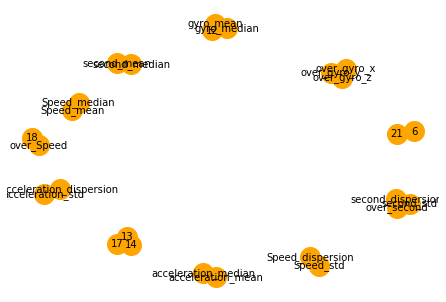

In [118]:
corr.plot()